In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow import keras 
from keras.datasets import mnist  
from keras.layers import Input,Dense,Reshape,Flatten 
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU  
from keras.models import Sequential,Model  
from tensorflow.keras.optimizers import Adam
import random 
%matplotlib inline

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(f"Shape of x_train: {X_train.shape}")
print(f"Shape of y_train: {Y_train.shape}")
print()
print(f"Shape of x_test: {X_test.shape}")
print(f"Shape of y_test: {Y_test.shape}")

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


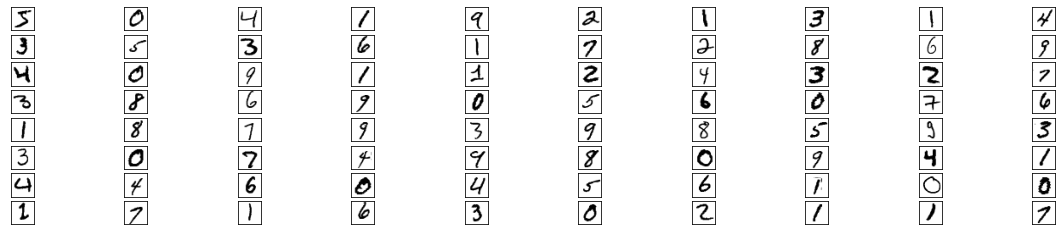

In [3]:
plt.figure(figsize=(20,4))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(X_train[i], cmap = plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])    
plt.show()

In [4]:
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

In [5]:
#generator

noise_shape = (100,)
img_shape = (28,28,1)

model = Sequential()
model.add(Dense(256, input_shape=noise_shape))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.10))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.10))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.10))
model.add(Dense(784, activation='tanh'))
model.add(Reshape(img_shape))

model.summary()

noise = Input(shape=noise_shape)
img = model(noise)

generator =  Model(inputs = noise, outputs = img)

optimizer = Adam(0.0002, 0.5)
generator.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

In [6]:
#discriminator

model = Sequential()

model.add(Flatten(input_shape=img_shape))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

img = Input(shape=img_shape)
validity = model(img)

discriminator =  Model(inputs = img, outputs = validity)
discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [7]:
#combining generator and discriminator
z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

#valid takes generated images as input
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         1493520   
_________________________________________________________________
model_1 (Functional)         (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [8]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
h = model.fit(x=X_train, y=Y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 [==============================] - 4s 3ms/step - loss: 4.4120 - accuracy: 0.0866 - val_loss: 4.3981 - val_accuracy: 0.0887
Epoch 2/5
750/750 [==============================] - 2s 2ms/step - loss: 4.4120 - accuracy: 0.0866 - val_loss: 4.3981 - val_accuracy: 0.0887
Epoch 3/5
750/750 [==============================] - 2s 2ms/step - loss: 4.4120 - accuracy: 0.0866 - val_loss: 4.3981 - val_accuracy: 0.0887
Epoch 4/5
750/750 [==============================] - 2s 2ms/step - loss: 4.4120 - accuracy: 0.0866 - val_loss: 4.3981 - val_accuracy: 0.0887
Epoch 5/5
750/750 [==============================] - 2s 2ms/step - loss: 4.4120 - accuracy: 0.0866 - val_loss: 4.3981 - val_accuracy: 0.0887


In [9]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    #rescale images 0 to 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap = plt.cm.gray_r)
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

Epoch: 0, Discrimination Loss: 0.130092, Discrimination Accuracy.: 99.22% Generator Loss: 1.816895


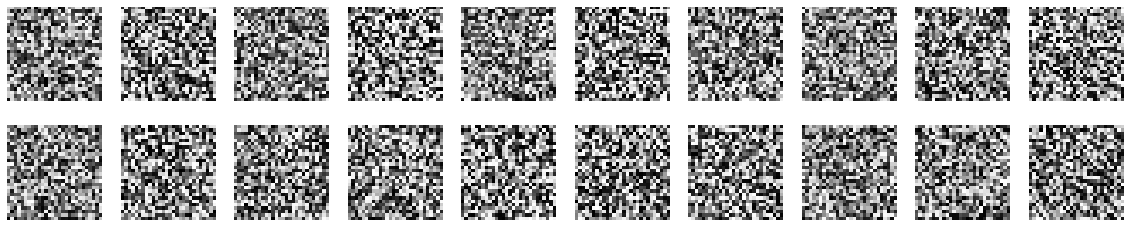

In [11]:
epochs = 5
batch_size = 128
print_interval = 2000
losses=[]

half_batch = int(batch_size / 2)

for epoch in range(epochs):

    #discriminator training with half batch
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))

    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    #generator training with half batch
    noise = np.random.normal(0, 1, (batch_size, 100))
    
    valid_y = np.array([1] * batch_size)

    g_loss = combined.train_on_batch(noise, valid_y)
    losses.append((d_loss[0], g_loss, d_loss[1]))


    if epoch % print_interval == 0:
        print ("Epoch: %d, Discrimination Loss: %f, Discrimination Accuracy.: %.2f%% Generator Loss: %f" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        print_imgs()

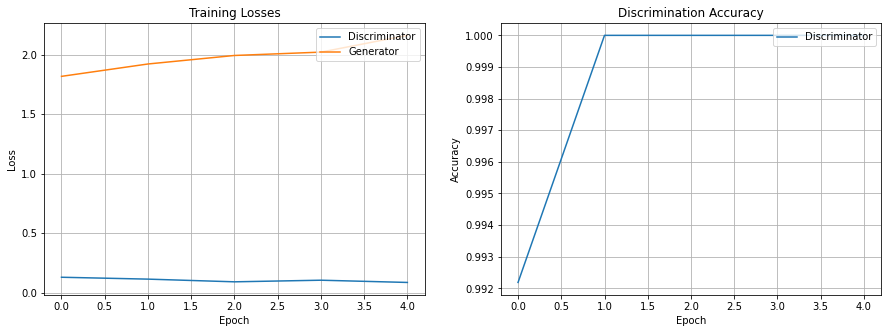

In [12]:
losses = np.array(losses)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(losses.T[2], label='Discriminator')
plt.title("Discrimination Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='upper right')

In [13]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
h = model.fit(x=X_train, y=Y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 2s 2ms/step - loss: -15.9558 - accuracy: 0.1140 - val_loss: -16.1625 - val_accuracy: 0.1060
Epoch 2/10
750/750 [==============================] - 2s 2ms/step - loss: -15.9559 - accuracy: 0.1140 - val_loss: -16.1625 - val_accuracy: 0.1060
Epoch 3/10
750/750 [==============================] - 2s 2ms/step - loss: -15.9559 - accuracy: 0.1140 - val_loss: -16.1625 - val_accuracy: 0.1060
Epoch 4/10
750/750 [==============================] - 2s 2ms/step - loss: -15.9559 - accuracy: 0.1140 - val_loss: -16.1625 - val_accuracy: 0.1060
Epoch 5/10
750/750 [==============================] - 2s 2ms/step - loss: -15.9559 - accuracy: 0.1140 - val_loss: -16.1625 - val_accuracy: 0.1060
Epoch 6/10
750/750 [==============================] - 2s 2ms/step - loss: -15.9558 - accuracy: 0.1140 - val_loss: -16.1625 - val_accuracy: 0.1060
Epoch 7/10
750/750 [==============================] - 2s 2ms/step - loss: -15.9559 - accuracy: 0.1140 - val_loss: -16.1625 -

In [14]:
predictions = model.predict(X_test)

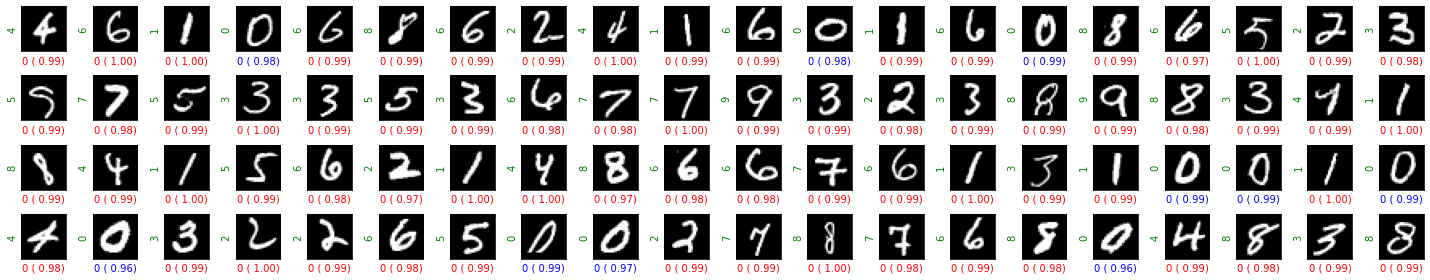

In [15]:
ROWS = 4
COLS = 20

random_indices = random.sample(range(X_train.shape[0]), ROWS*COLS)
sample_images = X_train[random_indices, :]
sample_labels = Y_train[random_indices]
predictions = model.predict(sample_images)

i = 0

plt.figure(figsize=(20,4))
for r in range(ROWS):
    for c in range(COLS):
        plt.subplot(ROWS, COLS, i+1)
        plt.imshow(sample_images[i].reshape(28,28), cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
        prediction = np.argmax(predictions[i]) 
        confidence = predictions[i][prediction]
        if sample_labels[i] == prediction:
            plt.xlabel(f"{prediction} ({confidence: .2f})", color='b')
        else:
            plt.xlabel(f"{prediction} ({confidence: .2f})", color='r')
        plt.ylabel(sample_labels[i], color='g')
        i += 1
        
plt.tight_layout()
plt.show()